# **CARGA Y PROCESAMIENTO DE AFFECTNET**

## **0. Importacion de Librerias**

In [ ]:
#@title importando
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings
from IPython.display import display
import IPython
#!pip install sweetviz
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install tqdm
#import sweetviz as sv
import cv2
#import pandas_profiling
#from pandas_profiling import ProfileReport
import imgaug.augmenters as iaa
from tqdm.notebook  import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
!pip install mediapipe
import mediapipe
import cv2

warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Carga Y copia de la data**

In [ ]:
#@title funciones
# Datos de entrenamiento
#from glob import glob
def show_data(ROOT_PATH_DATA, type_data):
  DATA_PATH=ROOT_PATH_DATA
  TRAIN_PATH = os.path.join(DATA_PATH, type_data)
  list_dire_clases= [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
  list_name_clases = [os.path.basename(x) for x in list_dire_clases]
  cantidades = []
  limit = 4200
  print()
  for class_path, class_name in zip(list_dire_clases, list_name_clases):
    files_annot = glob.glob(os.path.join(class_path, "*.jpg"))
    files_names = [os.path.basename(x) for x in files_annot]
    print(f"Clase {class_name} tiene {len(files_annot)} registros")
    tama = len(files_annot)
    cantidades.append(len(files_annot))
    #ajustar_affecnetdata(files_annot, files_names, class_name, limit)
  plt.bar(list_name_clases,cantidades)
  plt.xticks(rotation=45)
  plt.show()

In [ ]:
#@title Funciones
from tqdm.notebook  import tqdm
import numpy as np
import tarfile
import os
def format_data(ROOT_PATH_DATA, type_data):
  files_annot = glob.glob("/content/data/"+type_data + "_set"+"/annotations/*_exp.npy")
  files_imgs = [os.path.basename(x) for x in files_annot]
  print(f"Procesando datos de {type_data} , tamaño:{len(files_imgs)}")
  save_path = os.path.join(ROOT_PATH_DATA, type_data)
  if not os.path.exists(save_path):
      os.makedirs(save_path)
  pbar = tqdm(total=len(files_imgs))
  for file_n, file_a in zip(files_imgs,files_annot) :
    pbar.update(1)
    pos = file_n.find("_")
    img_name = file_n[:pos] + ".jpg"
    img_path = os.path.join(ROOT_PATH, type_data + "_set", "images",img_name)
    category = np.load(file_a, encoding='bytes')
    category = categories[int(category)]
    save_path_class = os.path.join(save_path, str(category))
    if not os.path.exists(save_path_class):
          os.makedirs(save_path_class)
    
    new_dir=os.path.join(save_path_class , img_name)
    #print("Guardando imagen ", img_name, " en set ", str(category))
    try:
      shutil.copy(img_path, new_dir)
    except ValueError:
      print(f"{img_name} No encontrado, pasando al siguiente")
  pbar.close()
  print("Proceso finalizado...")

def copy_data(type_data):
  root_path = "/content/drive/MyDrive/Datasets/dataset UCSP/affect_net_original/"+type_data+".tar"
  #root_path = "/content/drive/MyDrive/Datasets/dataset UCSP/affect_net_original/val_set.tar"
  save_path_class ="data"
  if not os.path.exists(save_path_class):
      os.makedirs(save_path_class)

  if root_path.endswith("tar.gz"):
      tar = tarfile.open(root_path, "r:gz")
      tar.extractall(save_path_class)
      tar.close()
  elif root_path.endswith("tar"):
      tar = tarfile.open(root_path, "r:")
      tar.extractall(save_path_class)
      tar.close()

In [ ]:
%%time
copy_data("val_set")
copy_data("train_set")

CPU times: user 3min 43s, sys: 3min 20s, total: 7min 3s
Wall time: 9min 19s


In [ ]:
%%time
import glob
import os
import cv2
import shutil
from google.colab.patches import cv2_imshow
ROOT_PATH = "/content/data"
ROOT_PATH_DATA = "Affect_net_local"
categories = {0: "Neutral", 1: "Happiness", 2: "Sadness", 3: "Surprise", 4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt", 8: "None", 9: "Uncertain", 10: "No-Face"}

CPU times: user 14 µs, sys: 9 µs, total: 23 µs
Wall time: 29.3 µs


In [ ]:
format_data(ROOT_PATH_DATA, "train")
format_data(ROOT_PATH_DATA, "val")

Procesando datos de train , tamaño:287651


  0%|          | 0/287651 [00:00<?, ?it/s]

Proceso finalizado...
Procesando datos de val , tamaño:3999


  0%|          | 0/3999 [00:00<?, ?it/s]

Proceso finalizado...
CPU times: user 2min 34s, sys: 1min 13s, total: 3min 47s
Wall time: 11min 48s


In [ ]:
%%time
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/Affect_net_local", 'zip', "/content/Affect_net_local")

'/content/drive/MyDrive/Datasets/dataset UCSP/Affect_net_local.zip'

## **2.  Balance de datos**

In [ ]:
#@title Alignment
import math
from PIL import Image
def get_landmark_region(img, image_width, image_height, faceLandmarks, type_landmark): 
  matriz_landmark = []    
  #frame2 = cv2.resize(img, (image_width,image_height)) 
  for source_idx, target_idx in type_landmark:
    source = faceLandmarks.landmark[source_idx]
    target = faceLandmarks.landmark[target_idx]
    x1 = int(source.x * image_width)
    y1 = int(source.y * image_height)
    if x1 <= 0:
      x1 = 1
    if y1 <= 0:
      y1 = 1
    relative_x = (x1, y1)
    x2 = int(target.x * image_width)
    y2 = int(target.y * image_height)
    if x2 <= 0:
      x2 = 1
    if y2 <= 0:
      y2 = 1
    relative_y = (x2, y2)
    #draw_line_ladmarks(frame2, image_width, image_height, relative_x, relative_y, (0,0,255), 1)
    #cv2.line(frame2, relative_x, relative_y, (0,0,255),1)    
    matriz_landmark.append((relative_x, relative_y))
    #print((relative_x, relative_y))   
  #cv2_imshow(frame2) 
  return matriz_landmark

def draw_line_ladmarks(frame2, image_width, image_height, matrix, color, thickness):  
  # RECORDAR QUE LA MATRIZ DE TUPLAS ESTÁ ORDENADO DE MENOR A MAYOR EN EL EJE X   
  for idx, value in enumerate(matrix):
    cv2.line(frame2, value[0], value[1], color,thickness)
    #if idx == len(matrix)-1:
     # cv2.line(frame2, value[0], value[1], (0,255,255),3)
  
  x_min, x_max, y_min, y_max = get_min_max_values_tuples(matrix) 
  cv2.line(frame2, x_min[0], x_min[1], (0,255,255),3)
  cv2.line(frame2, x_max[0], x_max[1], (0,255,255),3)
  cv2.line(frame2, y_min[0], y_min[1], (255,255,0),3)
  cv2.line(frame2, y_max[0], y_max[1], (255,255,0),3)

def get_min_max_values_tuples(matriz_landmark):
  x_min = min(matriz_landmark, key = lambda t: t[0][0])
  x_max = max(matriz_landmark, key = lambda t: t[0][0])
  #print(x_min, x_max)
  y_min = min(matriz_landmark, key = lambda t: t[0][1])
  y_max = max(matriz_landmark, key = lambda t: t[0][1])
  #print(y_min, y_max)
  return(x_min, x_max, y_min, y_max)
  
def get_center(lineas):
    # Puntos @ (x, y) @ Frames
    matrix_np = np.zeros((len(lineas)*2, 2))
    index = []
    pos=0
    for p1, p2 in lineas:
        matrix_np[pos, 0] = p1[0]
        matrix_np[pos, 1] = p1[1]
        pos +=1
        matrix_np[pos, 0] = p2[0]
        matrix_np[pos, 1] = p2[1]
        pos +=1 
            #if i == ini:
            #    index.append([pos-1, pos])
    column_means = np.round(matrix_np.mean(axis=0), 0)
    return tuple(column_means.astype(int))

def rotate_image(img, left_eye_center, right_eye_center):
  #cv2.circle(img, left_eye_center, 2, (255, 0, 0) , 2)
  #cv2.circle(img, right_eye_center, 2, (255, 0, 0) , 2)
  #cv2.line(img,right_eye_center, left_eye_center,(67,67,67),2)
  left_eye_x  = left_eye_center[0];  left_eye_y  = left_eye_center[1]
  right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
  if left_eye_y < right_eye_y:
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock
    #print("rotate to clock direction")
  else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock
    #print("rotate to inverse clock direction")  
  #cv2.circle(img, point_3rd, 2, (255, 0, 0) , 2)
  #cv2.line(img,right_eye_center, left_eye_center,(67,67,67),2)
  #cv2.line(img,left_eye_center, point_3rd,(67,67,67),2)
  #cv2.line(img,right_eye_center, point_3rd,(67,67,67),2)
  a = euclidean_distance(left_eye_center, point_3rd)
  b = euclidean_distance(right_eye_center, left_eye_center)
  c = euclidean_distance(right_eye_center, point_3rd)
  cos_a = (b*b + c*c - a*a)/(2*b*c)
  angle = np.arccos(cos_a)
  angle = (angle * 180) / math.pi
  if direction == -1:
   angle = 90 - angle
  
  new_img = Image.fromarray(img)
  new_img = np.array(new_img.rotate(direction * angle))
  return new_img

def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return np.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))


In [ ]:
#@title Funciones
from google.colab.patches import cv2_imshow
drawingModule = mediapipe.solutions.drawing_utils
faceModule = mediapipe.solutions.face_mesh 
circleDrawingSpec = drawingModule.DrawingSpec(thickness=1, circle_radius=1, color=(255,255,255))
lineDrawingSpec = drawingModule.DrawingSpec(thickness=1, color=(0,255,255))

def ajustar_affecnetdata(files_annot, files_names, expresion_name, limit, folder, saved_path):
  #verificamos el tamaño de las muestras 
  print(f"clase - {expresion_name}")
  print(f"...Se encontraron {len(files_annot)} muestras")
  print(f".....Seleccionando imágenes, por favor espere")
  sub_df = pd.Series(files_annot).sample(frac = 1)
  
  if limit ==-1:
     print(f"......Datos no se ajustan")
     n_samples = save_image2(sub_df, folder, expresion_name, 0, len(files_annot), files_names,saved_path, 0)
  elif len(sub_df)< limit:
    print(f"......Valor inferior al limite, se aplicará data-augmentation.")
    propor = round(limit/len(files_annot), 0)
    #if(propor == 1):
    #  propor = 2
    n_samples = save_image2(sub_df, folder, expresion_name, 0, len(files_annot), files_names,saved_path, int(propor))
  else:
    print(f"......Valor suoerior al limite, se reduciran las muestras hasta {limit}")
    n_samples = save_image2(sub_df, folder, expresion_name, 0, limit, files_names, saved_path)
  
  print(f"....... Guardadas un total de {n_samples} muestras.")

def save_image2(sub_df, tp_data, expresion_name, ini, fin, files_names, saved_path, augmented=0):
    image_new_dir = os.path.join(saved_path, tp_data, expresion_name)
    
    print(image_new_dir)
    cont = 0
    pbar = tqdm(total=fin-ini)
    for i in range(ini,fin):
      pbar.update(1)
      img = cv2.imread(sub_df[i])
      
      if (img is not None):
          cont+=1
          image_name = files_names[i]
          
          #cv2_imshow(img)
          if not os.path.exists(image_new_dir):
              os.makedirs(image_new_dir)
          # SI existe la imagen del rostro, guardamos la original en la carpeta
          #print(img.shape)
          #img = segment_face(img)
          #break
          if  img is None:
            continue
          
          cv2.imwrite(os.path.join(image_new_dir , image_name), img)
          #shutil.copy(sub_df[i], os.path.join(image_new_dir , image_name))
          #print("---------------Imagen Guardada...")

          if augmented > 0:
              image_aug = generate_augmentation(img, augmented-1)
              if (image_aug is None):
                  continue
              #print(".........................Guardando imágenes generadas..")

              for j in range(0, augmented-1):
                  face_name = image_name[0:-4]+ "_" + str(j) + ".jpg"
                  img = image_aug[j].astype(np.uint8)
                  #img = segment_face(img)
                  if img is None:
                    continue

                  cv2.imwrite(os.path.join(image_new_dir , face_name), img)
                  cont+=1
                  if j==0 and i==ini:
                    cv2_imshow(img)

          if i == ini:
             cv2_imshow(img)
              #print(".........................Imágenes Generadas Guardadas..")
          #break
              
    pbar.close()

    return cont
from skimage.measure import label, regionprops

def segment_face(x, opt):
  # opt = 2: segmentar
  # opt = 3: Alinear
  # opt = 4: segmentar y alinear
  with faceModule.FaceMesh(static_image_mode=True) as face:
    #x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    img = x.copy()    

    results = face.process(x)
    if results.multi_face_landmarks != None:
      for indice, faceLandmarks  in enumerate(results.multi_face_landmarks):
            if opt  == 2 or opt == 4: #segmentar
              #drawingModule.draw_landmarks(x, faceLandmarks, faceModule.FACEMESH_CONTOURS, circleDrawingSpec, lineDrawingSpec)
              #cv2_imshow(x)
              idx_to_coordinates = []
              for idx, landmark in enumerate(faceLandmarks.landmark):
                  landmark_px = drawingModule._normalized_to_pixel_coordinates(landmark.x, landmark.y,x.shape[0], x.shape[1])
                  if landmark_px:
                    idx_to_coordinates.append(landmark_px)
              idx_to_coordinates = np.array(idx_to_coordinates)
              #print(idx_to_coordinates)
              hulls = cv2.convexHull(idx_to_coordinates)            
              cv2.drawContours(x, [hulls], -1, (255, 0, 0), 2)
              #cv2_imshow(x)
              hull = np.zeros((imgsize,imgsize), np.uint8)
              hull = cv2.drawContours(hull, np.array([np.squeeze(hulls)]), -1, 255, cv2.FILLED)
              idx = hull == 255
              final = img.copy()
              
              final[~idx, :] = 0#final[idx, :] + (0, 128, 0)
              props = regionprops(hull)[0]
              final = final[props.bbox[0]:props.bbox[2],props.bbox[1]:props.bbox[3]]
              final = cv2.resize(final, (imgsize,imgsize), interpolation = cv2.INTER_AREA)
              #final = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
              
              x = final
            if opt == 3 or opt==4: # solo alinear
              land_matrix = get_landmark_region(img, imgsize, imgsize, faceLandmarks, faceModule.FACEMESH_LEFT_EYE)
              left_eye_center = get_center(land_matrix)
              land_matrix = get_landmark_region(img, imgsize, imgsize, faceLandmarks, faceModule.FACEMESH_RIGHT_EYE)
              right_eye_center = get_center(land_matrix)
              x = rotate_image(x, left_eye_center, right_eye_center)
            #x[:,:,0] = final
            #x[:,:,1] = final
            #x[:,:,2] = final
           

            #cv2_imshow(x) 

    else:
      return None
  return x

def generate_augmentation(img, num_images):
    if num_images == 0:
        return None
    h = img.shape[0]
    w = img.shape[1]
    images = np.zeros((num_images,h,w,3))
    for i in range(0,num_images):
        images[i,:,:,:] = img

    sometimes = lambda aug: iaa.Sometimes(1, aug)
    #images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
    import imgaug as ia
    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values

    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            #iaa.Flipud(0.2), # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-13, 13), # rotate by -45 to +45 degrees
                shear=(-16, 16), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 4),
                [
                    #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation                
                    #iaa.ContrastNormalization((0.5, 1.0), per_channel=0.8), # improve or worsen the contrast
                    #iaa.Grayscale(alpha=(0.0, 1.0)),
                    #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )    
    image_aug = seq.augment_images(images)
    return image_aug

def process_faces(files_annot, files_names, class_name, type_data, save_data, opt):
  print(f"clase - {class_name}")
  print(f"...Se encontraron {len(files_annot)} muestras")
  print(f".....Seleccionando imágenes, por favor espere")
  pbar = tqdm(total=len(files_annot))
  for i, sample in enumerate(files_annot):
    pbar.update(1)
    #print(sample)
    img = cv2.imread(sample)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = segment_face(img, opt)
    if  img is None:
        continue
    
    if i==0:
      cv2_imshow(img)

    image_new_dir = os.path.join(save_data, type_data, class_name)
    if not os.path.exists(image_new_dir):
      os.makedirs(image_new_dir)

    cv2.imwrite(os.path.join(image_new_dir , files_names[i]), img)
  pbar.close()  


   



def process_data(ROOT_PATH_DATA, save_data, opt, type_data, limit=20000):
  list_dire_clases= [f.path for f in os.scandir(os.path.join(ROOT_PATH_DATA, type_data)) if f.is_dir()]
  list_name_clases = [os.path.basename(x) for x in list_dire_clases]
  list_name_clases
  cantidades = []
  
  print("*"*50)
  if opt == 1:
      print(f"Balance de datos a {limit} muestras")
  elif  opt == 2:
      print(f"Segmentando rostros desde \n {ROOT_PATH_DATA}")
      print(f"Rosotros segmentados se guardaran en \n {save_data}")
  elif opt == 3:
      print(f"Alineando rostros desde \n {ROOT_PATH_DATA}")
      print(f"Rostros Alineados se guardaran en \n {save_data}")
  else:
      print(f"segmentando y Alineando rostros desde \n {ROOT_PATH_DATA}")
      print(f"Rostros Segmentados y Alineados se guardaran en \n {save_data}")

  for class_path, class_name in zip(list_dire_clases, list_name_clases):   
      #files_annot = glob.glob(os.path.join(class_path, "*"))
      files_annot = glob.glob(os.path.join(class_path, "*.jpg"))
      files_names = [os.path.basename(x) for x in files_annot]
      print(f"Clase {class_name} tiene {len(files_annot)} registros")
      tama = len(files_annot)
      cantidades.append(len(files_annot))
      if opt == 1:
        ajustar_affecnetdata(files_annot, files_names, class_name, limit, type_data, save_data)
      else:
        process_faces(files_annot, files_names, class_name, type_data, save_data, opt)

      


In [ ]:
ROOT_PATH_DATA = "Affect_net_local"
balanced_path="Affect_net_local_balanced"
segmented_path="Affect_net_local_segment"
alignment_path="Affect_net_local_alignment"
seg_aligm_path="Affect_net_local_seg_alig"

In [ ]:
show_data(ROOT_PATH_DATA, "train")
show_data(ROOT_PATH_DATA, "val")

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
%%time
process_data(ROOT_PATH_DATA, balanced_path, 1, "train", limit = 23000)
process_data(ROOT_PATH_DATA, balanced_path, 1, "val", limit = -1)
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/"+balanced_path, 'zip', balanced_path)


Clase Contempt tiene 22500 registros
Clase Sadness tiene 23000 registros
Clase Fear tiene 25512 registros
Clase Disgust tiene 22818 registros
Clase Surprise tiene 28180 registros
Clase Anger tiene 23000 registros
Clase Happiness tiene 23000 registros
Clase Neutral tiene 23000 registros


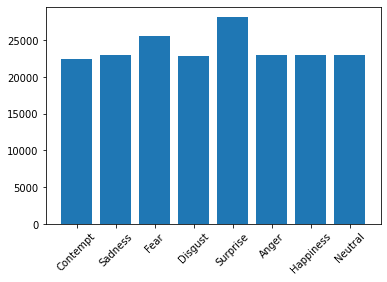


Clase Contempt tiene 499 registros
Clase Sadness tiene 500 registros
Clase Fear tiene 500 registros
Clase Disgust tiene 500 registros
Clase Surprise tiene 500 registros
Clase Anger tiene 500 registros
Clase Happiness tiene 500 registros
Clase Neutral tiene 500 registros


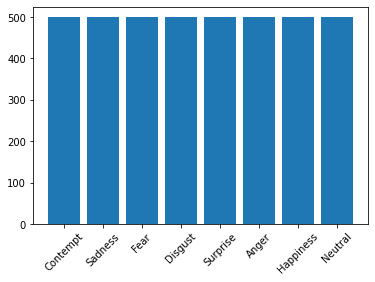

In [ ]:
show_data(balanced_path, "train")
show_data(balanced_path, "val")

**************************************************
Segmentando rostros desde 
 Affect_net_local_balanced
Rosotros segmentados se guardaran en 
 Affect_net_local_segment
Clase Contempt tiene 22500 registros
clase - Contempt
...Se encontraron 22500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22500 [00:00<?, ?it/s]

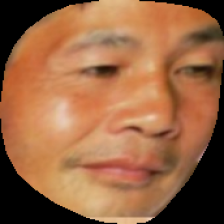

Clase Sadness tiene 23000 registros
clase - Sadness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

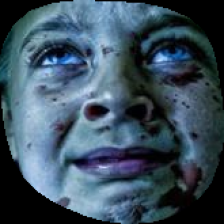

Clase Fear tiene 25512 registros
clase - Fear
...Se encontraron 25512 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/25512 [00:00<?, ?it/s]

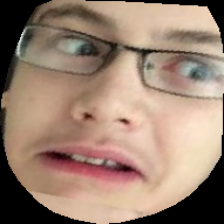

Clase Disgust tiene 22818 registros
clase - Disgust
...Se encontraron 22818 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22818 [00:00<?, ?it/s]

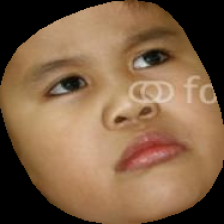

Clase Surprise tiene 28180 registros
clase - Surprise
...Se encontraron 28180 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/28180 [00:00<?, ?it/s]

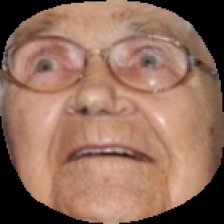

Clase Anger tiene 23000 registros
clase - Anger
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

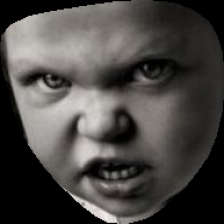

Clase Happiness tiene 23000 registros
clase - Happiness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

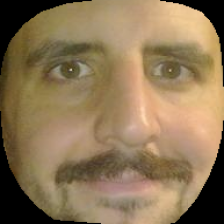

Clase Neutral tiene 23000 registros
clase - Neutral
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

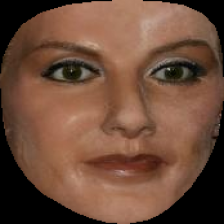

**************************************************
Segmentando rostros desde 
 Affect_net_local_balanced
Rosotros segmentados se guardaran en 
 Affect_net_local_segment
Clase Contempt tiene 499 registros
clase - Contempt
...Se encontraron 499 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/499 [00:00<?, ?it/s]

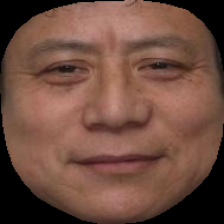

Clase Sadness tiene 500 registros
clase - Sadness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

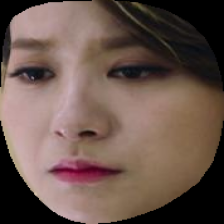

Clase Fear tiene 500 registros
clase - Fear
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

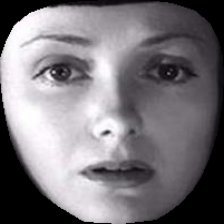

Clase Disgust tiene 500 registros
clase - Disgust
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

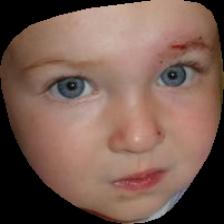

Clase Surprise tiene 500 registros
clase - Surprise
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

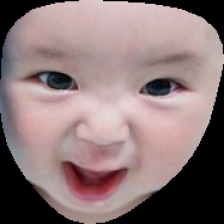

Clase Anger tiene 500 registros
clase - Anger
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

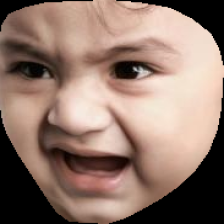

Clase Happiness tiene 500 registros
clase - Happiness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

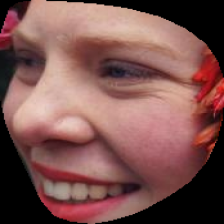

Clase Neutral tiene 500 registros
clase - Neutral
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

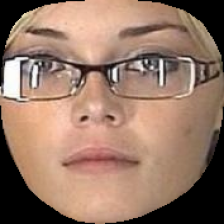


Clase Contempt tiene 21697 registros
Clase Sadness tiene 21889 registros
Clase Fear tiene 23661 registros
Clase Disgust tiene 21083 registros
Clase Surprise tiene 26897 registros
Clase Anger tiene 21627 registros
Clase Happiness tiene 22550 registros
Clase Neutral tiene 22271 registros


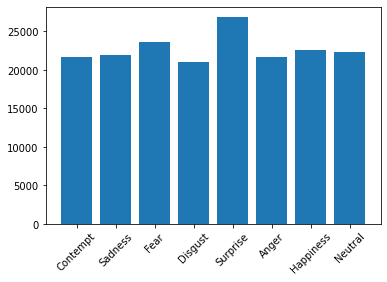


Clase Contempt tiene 494 registros
Clase Sadness tiene 485 registros
Clase Fear tiene 480 registros
Clase Disgust tiene 491 registros
Clase Surprise tiene 490 registros
Clase Anger tiene 467 registros
Clase Happiness tiene 492 registros
Clase Neutral tiene 485 registros


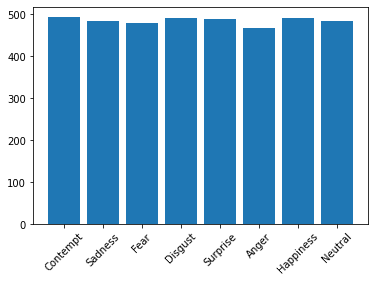

CPU times: user 2h 7min 9s, sys: 9min 51s, total: 2h 17min
Wall time: 2h 1min 33s


In [ ]:
%%time
process_data(balanced_path, segmented_path, 2, "train")
process_data(balanced_path, segmented_path, 2, "val")
show_data(segmented_path, "train")
show_data(segmented_path, "val")
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/"+segmented_path, 'zip', segmented_path)

**************************************************
Alineando rostros desde 
 Affect_net_local_balanced
Rostros Alineados se guardaran en 
 Affect_net_local_alignment
Clase Contempt tiene 22500 registros
clase - Contempt
...Se encontraron 22500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22500 [00:00<?, ?it/s]

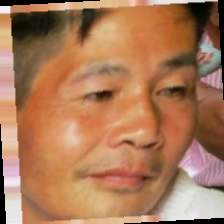

Clase Sadness tiene 23000 registros
clase - Sadness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

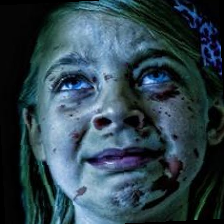

Clase Fear tiene 25512 registros
clase - Fear
...Se encontraron 25512 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/25512 [00:00<?, ?it/s]

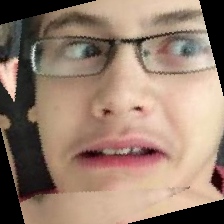

Clase Disgust tiene 22818 registros
clase - Disgust
...Se encontraron 22818 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22818 [00:00<?, ?it/s]

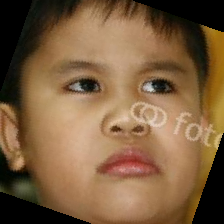

Clase Surprise tiene 28180 registros
clase - Surprise
...Se encontraron 28180 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/28180 [00:00<?, ?it/s]

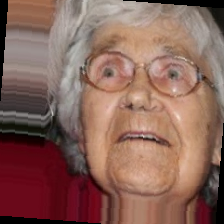

Clase Anger tiene 23000 registros
clase - Anger
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

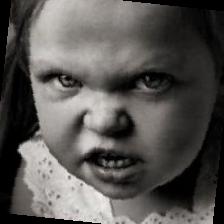

Clase Happiness tiene 23000 registros
clase - Happiness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

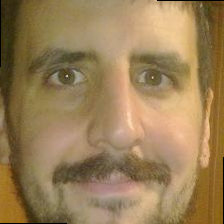

Clase Neutral tiene 23000 registros
clase - Neutral
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

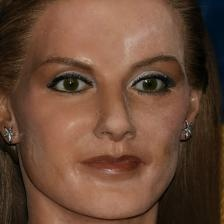

**************************************************
Alineando rostros desde 
 Affect_net_local_balanced
Rostros Alineados se guardaran en 
 Affect_net_local_alignment
Clase Contempt tiene 499 registros
clase - Contempt
...Se encontraron 499 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/499 [00:00<?, ?it/s]

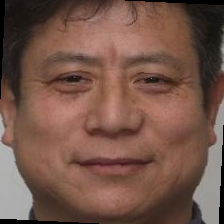

Clase Sadness tiene 500 registros
clase - Sadness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

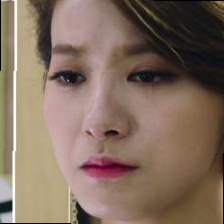

Clase Fear tiene 500 registros
clase - Fear
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

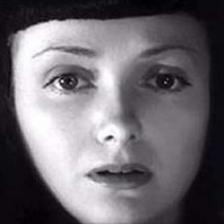

Clase Disgust tiene 500 registros
clase - Disgust
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

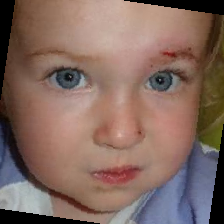

Clase Surprise tiene 500 registros
clase - Surprise
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

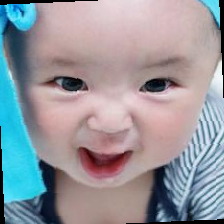

Clase Anger tiene 500 registros
clase - Anger
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

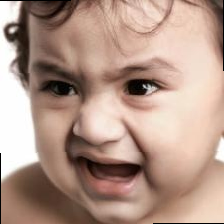

Clase Happiness tiene 500 registros
clase - Happiness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

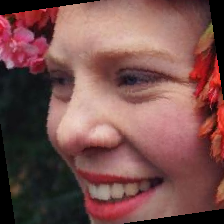

Clase Neutral tiene 500 registros
clase - Neutral
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

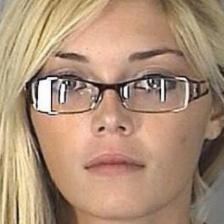


Clase Contempt tiene 21697 registros
Clase Sadness tiene 21889 registros
Clase Fear tiene 23661 registros
Clase Disgust tiene 21083 registros
Clase Surprise tiene 26897 registros
Clase Anger tiene 21627 registros
Clase Happiness tiene 22550 registros
Clase Neutral tiene 22271 registros


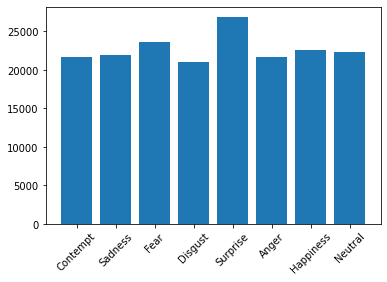


Clase Contempt tiene 494 registros
Clase Sadness tiene 485 registros
Clase Fear tiene 480 registros
Clase Disgust tiene 491 registros
Clase Surprise tiene 490 registros
Clase Anger tiene 467 registros
Clase Happiness tiene 492 registros
Clase Neutral tiene 485 registros


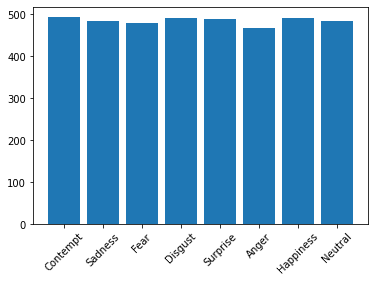

CPU times: user 1h 53min 14s, sys: 9min 47s, total: 2h 3min 2s
Wall time: 1h 47min 39s


In [ ]:
%%time
process_data(balanced_path, alignment_path, 3, "train")
process_data(balanced_path, alignment_path, 3, "val")
show_data(alignment_path, "train")
show_data(alignment_path, "val")
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/"+alignment_path, 'zip', alignment_path)

**************************************************
segmentando y Alineando rostros desde 
 Affect_net_local_balanced
Rostros Segmentados y Alineados se guardaran en 
 Affect_net_local_seg_alig
Clase Contempt tiene 22500 registros
clase - Contempt
...Se encontraron 22500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22500 [00:00<?, ?it/s]

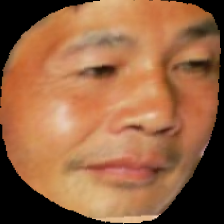

Clase Sadness tiene 23000 registros
clase - Sadness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

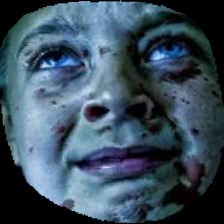

Clase Fear tiene 25512 registros
clase - Fear
...Se encontraron 25512 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/25512 [00:00<?, ?it/s]

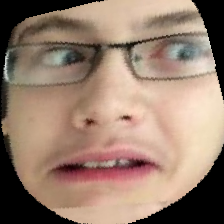

Clase Disgust tiene 22818 registros
clase - Disgust
...Se encontraron 22818 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/22818 [00:00<?, ?it/s]

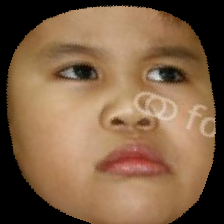

Clase Surprise tiene 28180 registros
clase - Surprise
...Se encontraron 28180 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/28180 [00:00<?, ?it/s]

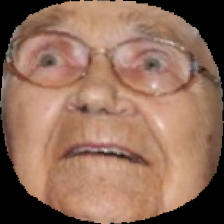

Clase Anger tiene 23000 registros
clase - Anger
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

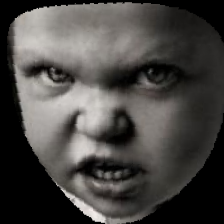

Clase Happiness tiene 23000 registros
clase - Happiness
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

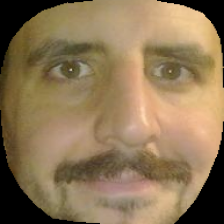

Clase Neutral tiene 23000 registros
clase - Neutral
...Se encontraron 23000 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/23000 [00:00<?, ?it/s]

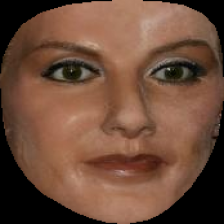

**************************************************
segmentando y Alineando rostros desde 
 Affect_net_local_balanced
Rostros Segmentados y Alineados se guardaran en 
 Affect_net_local_seg_alig
Clase Contempt tiene 499 registros
clase - Contempt
...Se encontraron 499 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/499 [00:00<?, ?it/s]

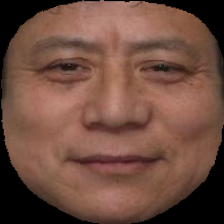

Clase Sadness tiene 500 registros
clase - Sadness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

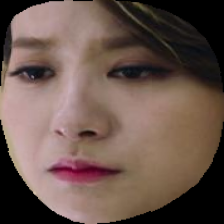

Clase Fear tiene 500 registros
clase - Fear
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

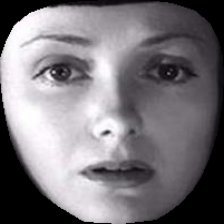

Clase Disgust tiene 500 registros
clase - Disgust
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

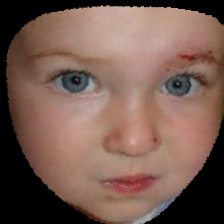

Clase Surprise tiene 500 registros
clase - Surprise
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

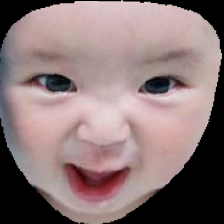

Clase Anger tiene 500 registros
clase - Anger
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

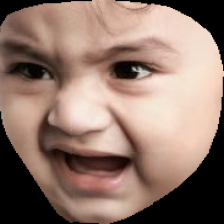

Clase Happiness tiene 500 registros
clase - Happiness
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

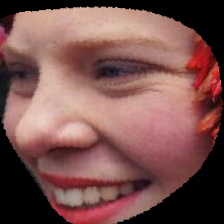

Clase Neutral tiene 500 registros
clase - Neutral
...Se encontraron 500 muestras
.....Seleccionando imágenes, por favor espere


  0%|          | 0/500 [00:00<?, ?it/s]

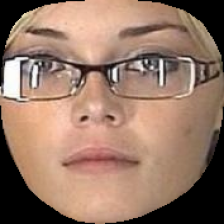


Clase Contempt tiene 21697 registros
Clase Sadness tiene 21889 registros
Clase Fear tiene 23661 registros
Clase Disgust tiene 21083 registros
Clase Surprise tiene 26897 registros
Clase Anger tiene 21627 registros
Clase Happiness tiene 22550 registros
Clase Neutral tiene 22271 registros


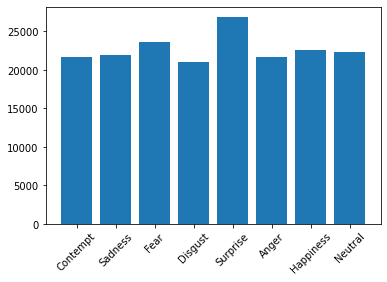


Clase Contempt tiene 494 registros
Clase Sadness tiene 485 registros
Clase Fear tiene 480 registros
Clase Disgust tiene 491 registros
Clase Surprise tiene 490 registros
Clase Anger tiene 467 registros
Clase Happiness tiene 492 registros
Clase Neutral tiene 485 registros


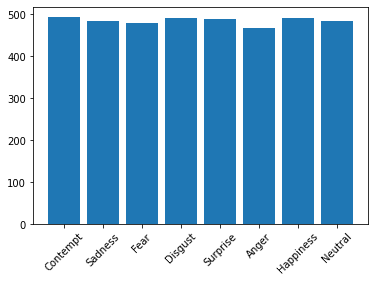

CPU times: user 1h 58min 24s, sys: 9min 16s, total: 2h 7min 40s
Wall time: 1h 54min 27s


In [ ]:
%%time
process_data(balanced_path, seg_aligm_path, 4, "train")
process_data(balanced_path, seg_aligm_path, 4, "val")
show_data(seg_aligm_path, "train")
show_data(seg_aligm_path, "val")
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/"+seg_aligm_path, 'zip', seg_aligm_path)

# **CARGA DE FER 2013**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/icml_face_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
data.loc[data[' Usage']=='Training', " Usage"] = "train"
data.loc[data[' Usage']=='PublicTest', " Usage"] = "test"
data.loc[data[' Usage']=='PrivateTest', " Usage"] = "valid"
data[" Usage"].unique()

array(['train', 'test', 'valid'], dtype=object)

In [ ]:
image_array, image_label, image_type=prepare_data(data)

In [ ]:
image_array, image_label, image_type=prepare_data(data)

Extrayendo datos


  0%|          | 0/35887 [00:00<?, ?it/s]

In [ ]:
#@title funciones
def prepare_data(data):
    rooth_path = "FEAR2013"
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    image_type  = np.array(data[' Usage'].values)
    print("Extrayendo datos")
    pbar = tqdm(total=len(data))
    for i, row in enumerate(data.index):
        pbar.update(1)
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
        image_new_dir = os.path.join(rooth_path, image_type[i], emotions[image_label[i]])
            
        if not os.path.exists(image_new_dir):
          os.makedirs(image_new_dir)
                  
        cv2.imwrite(os.path.join(image_new_dir, "sample_"+str(i)+".jpg"), image)
        
    return image_array, image_label, image_type
  


Clase Fear tiene 4097 registros
Clase Disgust tiene 436 registros
Clase Surprise tiene 3171 registros
Clase Angry tiene 3995 registros
Clase Happy tiene 7215 registros
Clase Neutral tiene 4965 registros
Clase Sad tiene 4830 registros


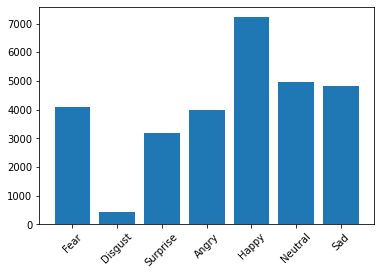

In [ ]:
import glob
show_data("/content/FEAR2013", "train")


Clase Fear tiene 528 registros
Clase Disgust tiene 55 registros
Clase Surprise tiene 416 registros
Clase Angry tiene 491 registros
Clase Happy tiene 879 registros
Clase Neutral tiene 626 registros
Clase Sad tiene 594 registros


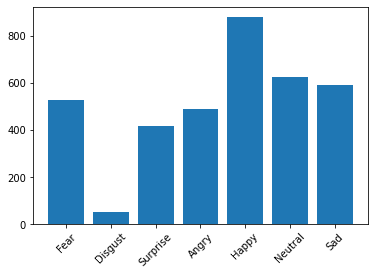

In [ ]:
show_data("/content/FEAR2013", "valid")


Clase Fear tiene 496 registros
Clase Disgust tiene 56 registros
Clase Surprise tiene 415 registros
Clase Angry tiene 467 registros
Clase Happy tiene 895 registros
Clase Neutral tiene 607 registros
Clase Sad tiene 653 registros


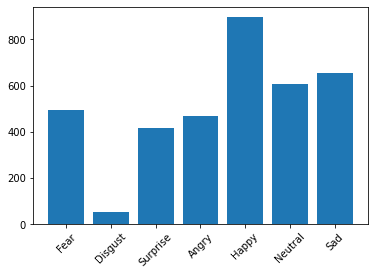

In [ ]:
show_data("/content/FEAR2013", "test")

In [ ]:
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/FEAR2013", "zip","/content/FEAR2013")

'/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/FEAR2013.zip'

In [ ]:
import shutil
ROOT_PATH_DATA = "/content/FEAR2013"
balanced_path="FEAR2013_balanced1"
segmented_path="FEAR2013_segment"
alignment_path="FEAR2013_alignment"
seg_aligm_path="FEAR2013_alig"

In [ ]:
%%time
process_data(ROOT_PATH_DATA, balanced_path, 1, "train", limit = 4000)
process_data(ROOT_PATH_DATA, balanced_path, 1, "valid", limit = 800)
process_data(ROOT_PATH_DATA, balanced_path, 1, "test", limit = -1)
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/"+balanced_path, 'zip', balanced_path)

In [ ]:
show_data(balanced_path, "train")
show_data(balanced_path, "valid")

In [ ]:
%%time
imgsize = 48
process_data(balanced_path, alignment_path, 3, "train")
process_data(balanced_path, alignment_path, 3, "valid")
process_data(balanced_path, alignment_path, 3, "test")
show_data(alignment_path, "train")
show_data(alignment_path, "valid")
#shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/"+segmented_path, 'zip', segmented_path)

In [ ]:
shutil.make_archive("/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/"+alignment_path, 'zip', alignment_path)

'/content/drive/MyDrive/Datasets/dataset UCSP/FER2013/FEAR2013_alignment.zip'

In [ ]:
%%time
imgsize = 48
process_data(balanced_path, segmented_path, 2, "train")
process_data(balanced_path, segmented_path, 2, "valid")
process_data(balanced_path, segmented_path, 2, "test")
show_data(segmented_path, "train")
show_data(segmented_path, "valid")

In [ ]:
show_data(segmented_path, "train")
show_data(segmented_path, "valid")